## Temporal sequence classification: CROHME dataset

Dataset:
https://www.cs.rit.edu/~rlaz/files/CROHME+TFD%E2%80%932019.pdf

Objective: 

- Recognize handwriting input sequences (mathematical expression)
- Output sequence of symbols + relations based on Symbol Relation Tree and Writing Order

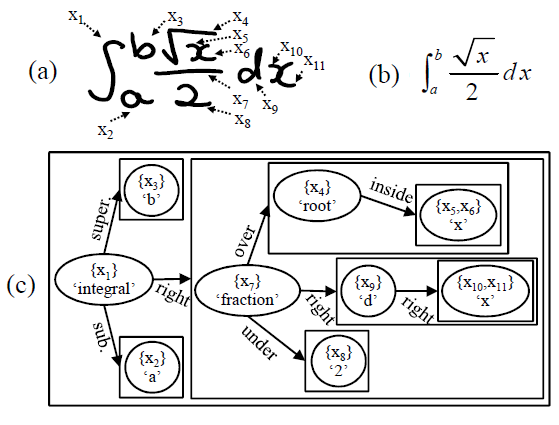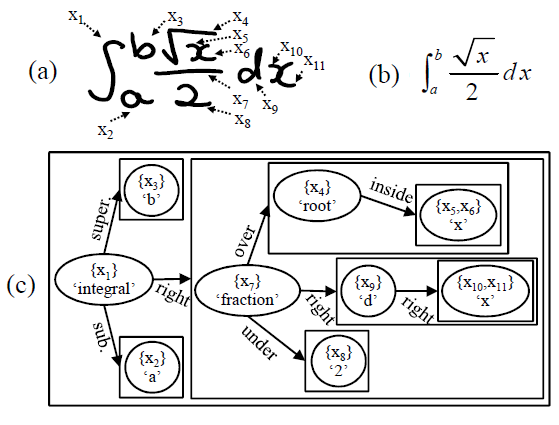

## Task 1: Dataloader

### 1.1 Build vocab



Input: 

```
/kaggle/input/crohme2019/crohme2019_train.txt
/kaggle/input/crohme2019/crohme2019_valid.txt
/kaggle/input/crohme2019/crohme2019_test.txt
```
Output:
```
crohme_vocab.txt
```

### Read an InkML files 

Visualize InkML file
https://www.cs.rit.edu/~rlaz/inkml_viewer/index.xhtml

In [4]:
import numpy as np

import xml.etree.ElementTree as ET

class Segment(object):
    """Class to reprsent a Segment compound of strokes (id) with an id and label."""
    __slots__ = ('id', 'label' ,'strId')
    def __init__(self, *args):
        if len(args) == 3:
            self.id = args[0]
            self.label = args[1]
            self.strId = args[2]
        else:
            self.id = "none"
            self.label = ""
            self.strId = set([])

class Inkml(object):
    """Class to represent an INKML file with strokes, segmentation and labels"""
    __slots__ = ('fileName', 'strokes', 'strkOrder','segments','truth','UI')

    NS = {'ns': 'http://www.w3.org/2003/InkML', 'xml': 'http://www.w3.org/XML/1998/namespace'}

    def __init__(self,*args):
        self.fileName = None
        self.strokes = {}
        self.strkOrder = []
        self.segments = {}
        self.truth = ""
        self.UI = ""
        if len(args) == 1:
            self.fileName = args[0]
            self.loadFromFile()
    
    def fixNS(self,ns,att):
        """Build the right tag or element name with namespace"""
        return '{'+Inkml.NS[ns]+'}'+att

    def loadFromFile(self):
        """load the ink from an inkml file (strokes, segments, labels)"""
        tree = ET.parse(self.fileName)
        # # ET.register_namespace();
        root = tree.getroot()
        for info in root.findall('ns:annotation',namespaces=Inkml.NS):
            if 'type' in info.attrib:
                if info.attrib['type'] == 'truth':
                    self.truth = info.text.strip()
                if info.attrib['type'] == 'UI':
                    self.UI = info.text.strip()
        for strk in root.findall('ns:trace',namespaces=Inkml.NS):
            self.strokes[strk.attrib['id']] = strk.text.strip()
            self.strkOrder.append(strk.attrib['id'])
        segments = root.find('ns:traceGroup',namespaces=Inkml.NS)
        if segments is None or len(segments) == 0:
            return
        for seg in (segments.iterfind('ns:traceGroup',namespaces=Inkml.NS)):
            id = seg.attrib[self.fixNS('xml','id')]
            label = seg.find('ns:annotation',namespaces=Inkml.NS).text
            strkList = set([])
            for t in seg.findall('ns:traceView',namespaces=Inkml.NS):
                strkList.add(t.attrib['traceDataRef'])
            self.segments[id] = Segment(id,label, strkList)
        
    def getTraces(self, height = 256):
        traces_array = [np.array([p.strip().split() 
            for p in self.strokes[id].split(',')], dtype='float') 
              for id in self.strkOrder ]
        
        ratio = height / ((np.concatenate(traces_array, 0).max(0) - np.concatenate(traces_array, 0).min(0))[1] + 1e-6)
        return [(trace * ratio).astype(int).tolist() for trace in traces_array]

In [5]:
ink = Inkml('/kaggle/input/crohme2019/crohme2019/crohme2019/valid/18_em_0.inkml')
[np.array(trace).shape for trace in ink.getTraces()]

[(525, 2),
 (113, 2),
 (118, 2),
 (328, 2),
 (350, 2),
 (96, 2),
 (130, 2),
 (115, 2),
 (293, 2),
 (304, 2),
 (111, 2),
 (133, 2),
 (265, 2),
 (329, 2),
 (103, 2),
 (132, 2)]

> The coordinations of pen traces (x, y) are obtain from collection device, origin at top left position. To visualize, the y coordination need to be inverted.

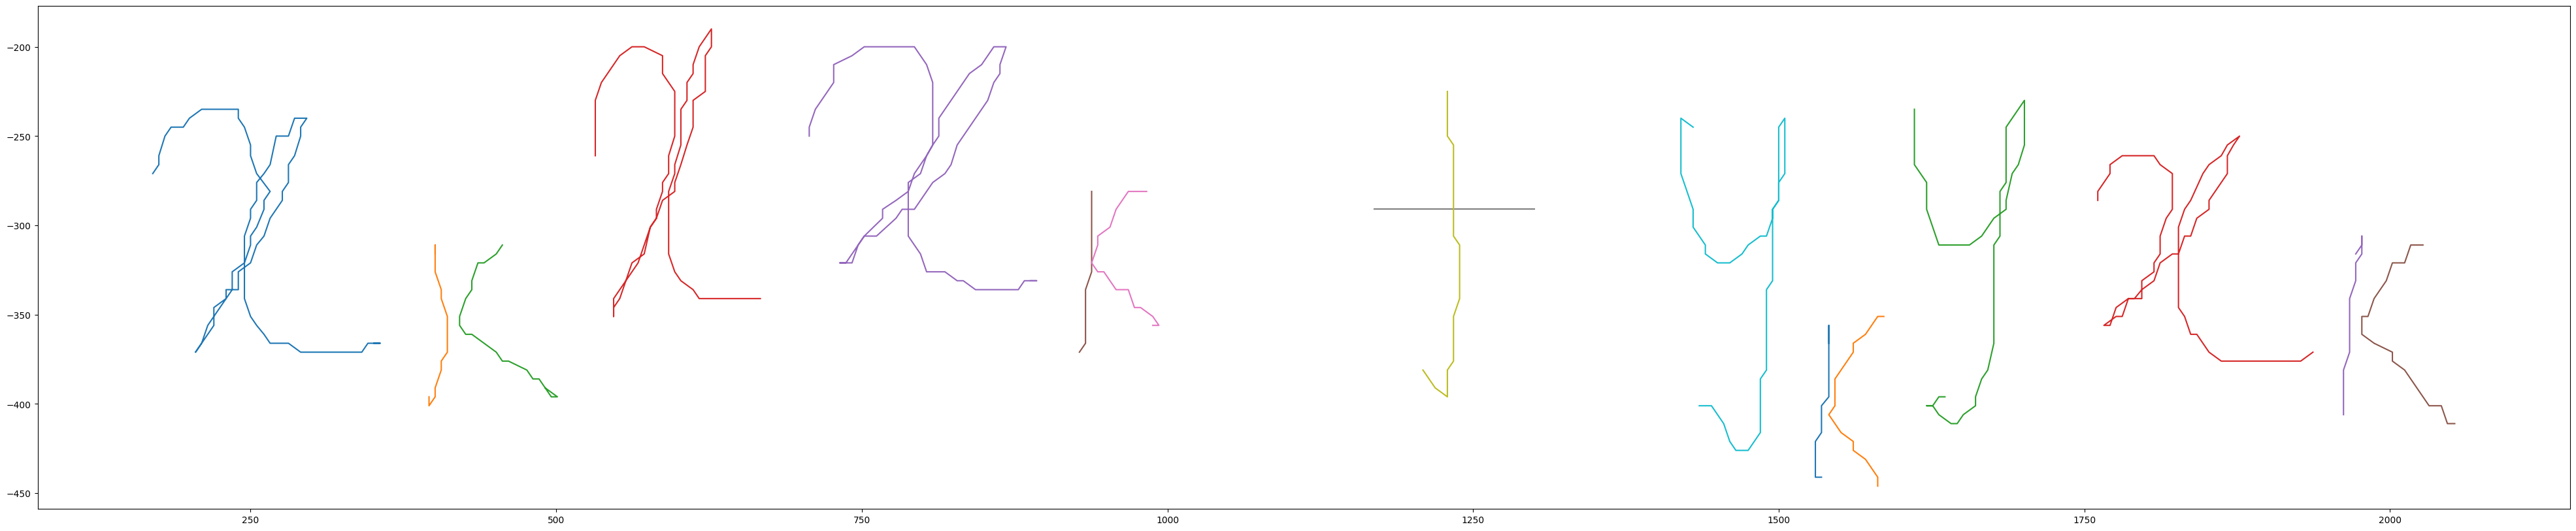

In [6]:
import matplotlib.pyplot as plt
plt.figure(figsize=(50,10))
for trace in ink.getTraces():
    trace_arr = np.array(trace)
    plt.plot(trace_arr[:, 0], - trace_arr[:, 1]) # invert y coordinate

### Dataset class

https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

torch.utils.data.Dataset is an abstract class representing a dataset. Your custom dataset should inherit Dataset and override the following methods:

- \_\_len\_\_ so that len(dataset) returns the size of the dataset.

- \_\_getitem\_\_ to support the indexing such that dataset[i] can be used to get ith sample.




In [7]:
from torch.utils.data import Dataset

class CROHME(Dataset):
    def __init__(self, annotation, root_dir):
        """
        Arguments:
            annotation (string): annotation file
            root_dir (string): Directory with all the images.
        """
        self.annotation = annotation
        self.root_dir = root_dir
        
        # load annotations
        self.ink_paths = []
        self.labels = []
        

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # read inkml sample --> traces
        
        # remove consecutive duplicate
        
        # extract features
        

        return feature, label


### Example of Dataset, Dataloader

In [9]:
from torch.utils.data import Dataset

class CROHME(Dataset):
    def __init__(self, annotation, root_dir):
        """
        Arguments:
            annotation (string): annotation file
            root_dir (string): Directory with all the images.
        """
        self.annotation = annotation
        self.root_dir = root_dir
        
        # load annotations
        self.ink_paths = []
        self.labels = []
        
        self.ink_paths, self.labels = list(zip(*[line.strip().split('\t') for line in open(self.annotation).readlines() if len(line.strip().split('\t')) == 2]))

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):        
        return self.ink_paths[idx], self.labels[idx]

In [10]:
crohme2019_test = CROHME(annotation = '/kaggle/input/crohme2019/crohme2019_test.txt', root_dir='/kaggle/input/crohme2019/crohme2019')

In [11]:
len(crohme2019_test)

1198

#### Test dataloader

In [12]:
from torch.utils.data import DataLoader
loader = DataLoader(crohme2019_test, shuffle=True, batch_size=4)
count = 0

# finish 1 epoch
for X_batch, y_batch in loader:
    count+=1
    if count == 300:
        print(len(X_batch))


2


In [14]:
X_batch, y_batch = next(iter(loader))
X_batch, y_batch

(('crohme2019/test/ISICal19_1201_em_750.inkml',
  'crohme2019/test/UN19_1015_em_209.inkml',
  'crohme2019/test/UN19wb_1113_em_1079.inkml',
  'crohme2019/test/UN19wb_1112_em_1055.inkml'),
 ('- Right - Above 1 NoRel 1 Right 9 Right 2',
  '( Right a Sup 2 NoRel COMMA Right a Right b Right + Right b Right a Right COMMA Right b Sup 2 NoRel + Right a Right c Right + Right c Right a Right COMMA Right a Right d Right + Right d Right a Right + Right b Right c Right + Right c Right b Right )',
  '9 NoRel - Below 7',
  '\\sin Right y Sub 0'))

In [24]:
crohme2019_test.__getitem__(1197)

('crohme2019/test/UN19_1038_em_543.inkml',
 '\\phi Right ( Right x Right ) Right = NoRel c Right ( Right \\sqrt Inside 1 Right + NoRel 4 Right x NoRel - Below a NoRel + Right 1 Right ) NoRel - Below 2 Right x NoRel ( Right 1 Right + NoRel c Right ( Right 1 Right + NoRel 4 Right x NoRel - Below a NoRel + Right 1 Right ) NoRel - Below 2 Right a Right x NoRel )')

In [18]:
crohme2019_test.ink_paths[:10]

('crohme2019/test/UN19_1032_em_455.inkml',
 'crohme2019/test/UN19_1044_em_632.inkml',
 'crohme2019/test/UN19wb_1111_em_1039.inkml',
 'crohme2019/test/UN19_1028_em_394.inkml',
 'crohme2019/test/UN19_1005_em_64.inkml',
 'crohme2019/test/UN19_1041_em_597.inkml',
 'crohme2019/test/UN19_1019_em_256.inkml',
 'crohme2019/test/UN19_1033_em_474.inkml',
 'crohme2019/test/UN19_1004_em_59.inkml',
 'crohme2019/test/UN19wb_1105_em_952.inkml')

### Dataloader



### Pytorch lightning dataloader

## Model

### Loss: CTC

### Pytorch lightning Module

https://lightning.ai/docs/pytorch/stable/common/lightning_module.html

A LightningModule organizes your PyTorch code into 6 sections:

Initialization (\_\_init\_\_ and setup()).

Train Loop (training_step())

Validation Loop (validation_step())

Test Loop (test_step())

Prediction Loop (predict_step())

Optimizers and LR Schedulers (configure_optimizers())



In [ ]:
from torchmetrics.functional import accuracy
import 

class ClassificationTask(L.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        loss = F.cross_entropy(y_hat, y)
        return loss

    def validation_step(self, batch, batch_idx):
        loss, acc = self._shared_eval_step(batch, batch_idx)
        metrics = {"val_acc": acc, "val_loss": loss}
        self.log_dict(metrics)
        return metrics

    def test_step(self, batch, batch_idx):
        loss, acc = self._shared_eval_step(batch, batch_idx)
        metrics = {"test_acc": acc, "test_loss": loss}
        self.log_dict(metrics)
        return metrics

    def _shared_eval_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        loss = F.cross_entropy(y_hat, y)
        acc = accuracy(y_hat, y)
        return loss, acc

    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        x, y = batch
        y_hat = self.model(x)
        return y_hat

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=0.02)
